In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen/') # to import ccsds
import ccsds

import struct
import collections
import pathlib

In [2]:
AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes
)

def packets_asarray(packets):
    packets = [np.frombuffer(p[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
               for p in packets]
    l = np.max([p.size for p in packets])
    packets = [np.concatenate((p, np.zeros(l-p.size, 'uint8'))) for p in packets]
    return np.array(packets)

def plot_apids(apids, vc=0):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0], interpolation='none')
        plt.title(f"Lucy APID {apid} Virtual channel {vc}")

Timestamps are contained in the Space Packet secondary header time code field. They are encoded as big-endian 32-bit integers counting the number of seconds elapsed since the J2000 epoch (2000-01-01T12:00:00).

Looking at the idle APID packets, the next byte might indicate fractional seconds (since it is still part of the secondary header rather than idle data), but it is difficult to be sure.

In [3]:
def timestamps(packets):
    epoch = np.datetime64('2000-01-01T12:00:00')
    t = np.array([struct.unpack('>I', p[ccsds.SpacePacketPrimaryHeader.sizeof():][:4])[0]
                  for p in packets], 'uint32')
    return epoch + t * np.timedelta64(1, 's')

In [4]:
def load_frames(path):
    frame_size = 223 * 5 - 2
    frames = np.fromfile(path, dtype = 'uint8')
    frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
    return frames

In [5]:
frames = np.concatenate((
    load_frames('lucy_frames_eb3frn_20211019_233036.u8'),
    load_frames('lucy_frames_eb3frn_20211019_235245.u8')))
frames.shape[0]

383

## AOS frames

Telemetry is in Virtual Channel 1. Virtual channel 63 contains Only Idle Data.

In [6]:
aos = [AOSFrame.parse(f) for f in frames]

In [7]:
collections.Counter([a.primary_header.transfer_frame_version_number for a in aos])

Counter({1: 383})

In [8]:
collections.Counter([a.primary_header.spacecraft_id for a in aos])

Counter({49: 383})

In [9]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos])

Counter({0: 52, 63: 331})

## Virtual Channel 63 (Only Idle Data)

Virtual channel 63 corresponds to Only Idle Data. The transfer frame data field includes an M_PDU header with a first header pointer equal to `0x7fe`, which indicates that the packet zone contains only idle data. The packet zone is filled with `0xaa`'s.

In [10]:
vc63 = [a for a in aos if a.primary_header.virtual_channel_id == 63]
[a.primary_header for a in vc63[:10]]

[Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=63, virtual_channel_frame_count=218263, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=63, virtual_channel_frame_count=218268, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=63, virtual_channel_frame_count=218271, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=63, virtual_channel_frame_count=218272, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=63, virtual_channel_frame_count=218275, replay_flag=False, vc_frame_count_u

In [11]:
vc63_frames = np.array([f for f, a in zip(frames, aos) if a.primary_header.virtual_channel_id == 63])

In [12]:
np.unique(vc63_frames[:, 6:8], axis = 0)

array([[  7, 254]], dtype=uint8)

In [13]:
bytes(vc63_frames[0, 6:8]).hex()

'07fe'

In [14]:
np.unique(vc63_frames[:, 8:])

array([170], dtype=uint8)

In [15]:
hex(170)

'0xaa'

In [16]:
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc63])

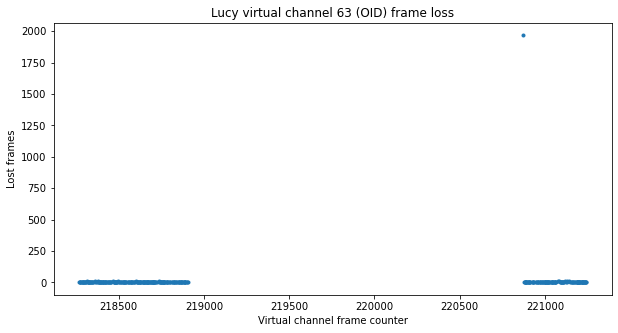

In [17]:
plt.figure(figsize = (10, 5), facecolor = 'w')
plt.plot(fc[1:], np.diff(fc)-1, '.')
plt.title("Lucy virtual channel 63 (OID) frame loss")
plt.xlabel('Virtual channel frame counter')
plt.ylabel('Lost frames');

In [18]:
first_part = fc < 219000
fc[first_part].size/(fc[first_part][-1]-fc[0]+1)

0.32866043613707163

## Virtual channel 0

Virtual channel 0 contains telemetry. There are a few active APIDs sending CCSDS Space Packets using the AOS M_PDU protocol.

In [19]:
vc0 = [a for a in aos if a.primary_header.virtual_channel_id == 0]
[a.primary_header for a in vc0[:10]]

[Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=0, virtual_channel_frame_count=995689, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=0, virtual_channel_frame_count=995690, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=0, virtual_channel_frame_count=995691, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=0, virtual_channel_frame_count=995693, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=49, virtual_channel_id=0, virtual_channel_frame_count=995700, replay_flag=False, vc_frame_count_usage_

In [20]:
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc0])

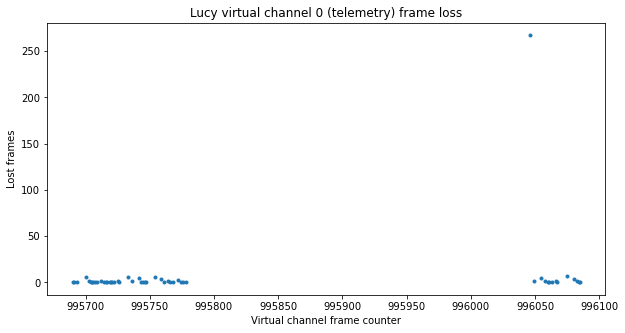

In [21]:
plt.figure(figsize = (10, 5), facecolor = 'w')
plt.plot(fc[1:], np.diff(fc)-1, '.')
plt.title("Lucy virtual channel 0 (telemetry) frame loss")
plt.xlabel('Virtual channel frame counter')
plt.ylabel('Lost frames');

In [22]:
first_part = fc < 995800
fc[first_part].size/(fc[first_part][-1]-fc[0]+1)

0.4222222222222222

In [23]:
vc0_packets = list(ccsds.extract_space_packets(vc0, 49, 0))

/home/daniel/jupyter_notebooks/Lucy/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 49 VC 0] Broken stream. Last frame count 995691, current frame count 995693
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/jupyter_notebooks/Lucy/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 49 VC 0] Broken stream. Last frame count 995693, current frame count 995700
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/jupyter_notebooks/Lucy/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 49 VC 0] Broken stream. Last frame count 995700, current frame count 995703
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame

In [24]:
vc0_t = timestamps(vc0_packets)

In [25]:
vc0_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc0_packets]

In [26]:
vc0_apids = collections.Counter([p.APID for p in vc0_sp_headers])
vc0_apids

Counter({1029: 2, 1030: 21, 2047: 38, 1032: 23, 7: 20, 5: 20, 1031: 2})

In [27]:
apid_axis = {a : k for k, a in enumerate(sorted(vc0_apids))}

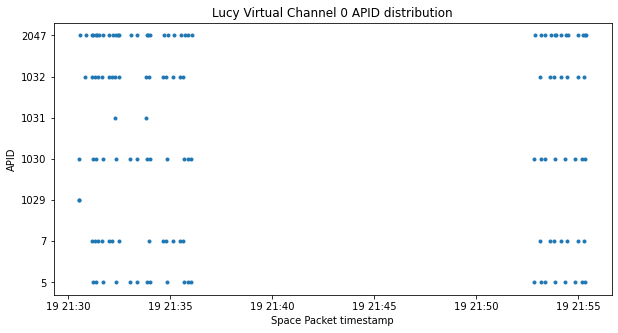

In [28]:
plt.figure(figsize = (10, 5), facecolor = 'w')
plt.plot(vc0_t, [apid_axis[p.APID] for p in vc0_sp_headers], '.')
plt.yticks(ticks=range(len(apid_axis)), labels=apid_axis)
plt.xlabel('Space Packet timestamp')
plt.ylabel('APID')
plt.title('Lucy Virtual Channel 0 APID distribution');

In [29]:
vc0_by_apid = {apid : [p for h,p in zip(vc0_sp_headers, vc0_packets)
                       if h.APID == apid] for apid in vc0_apids}

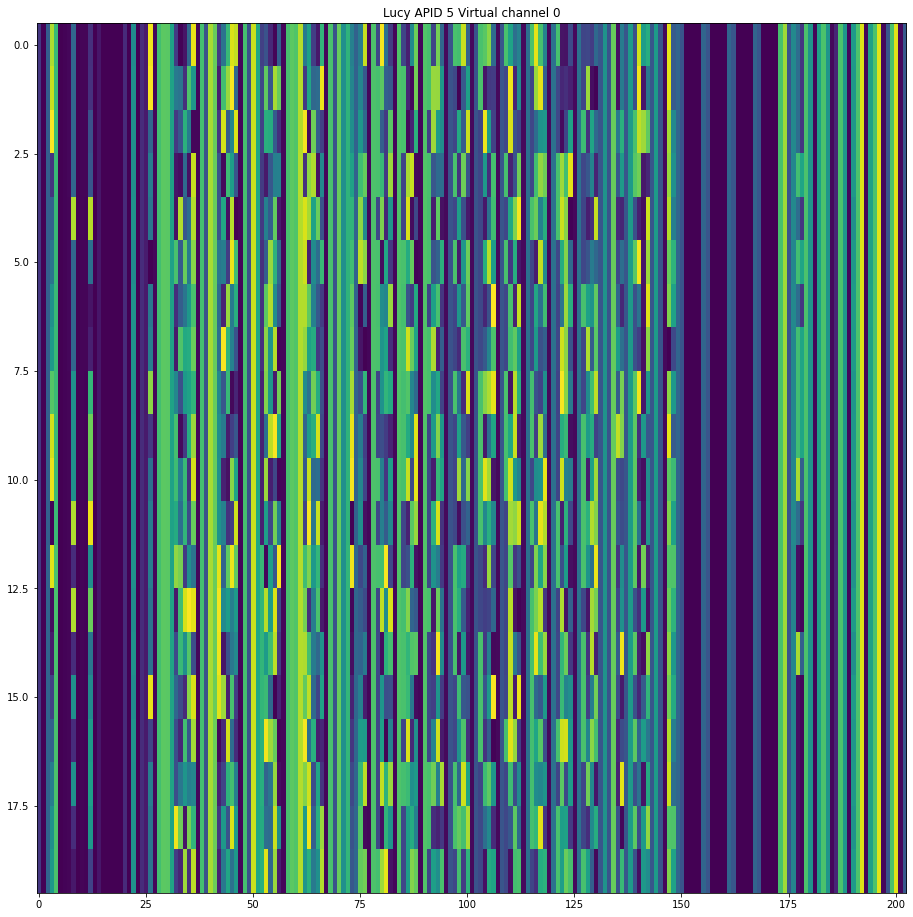

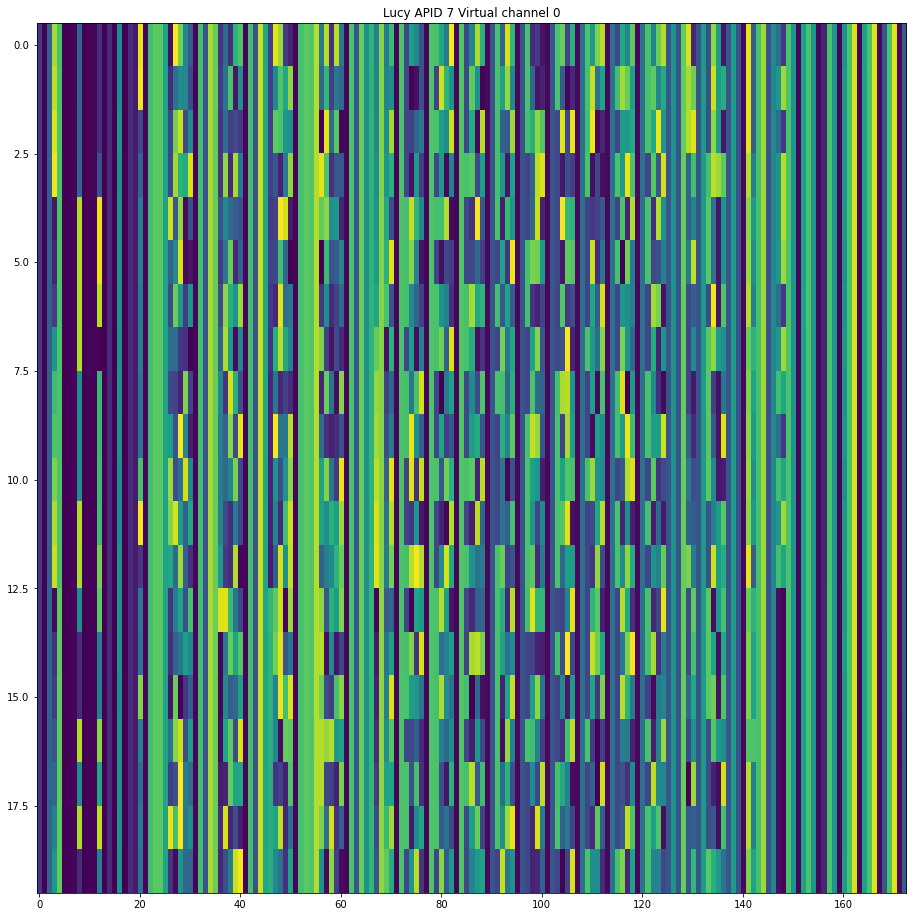

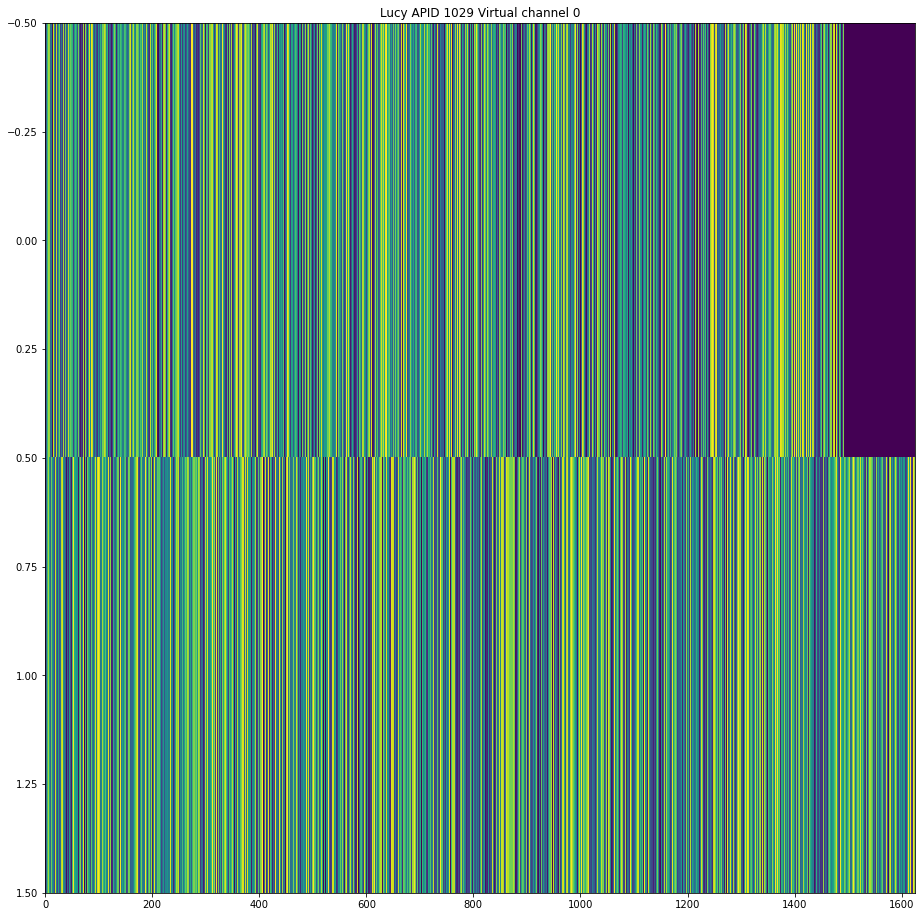

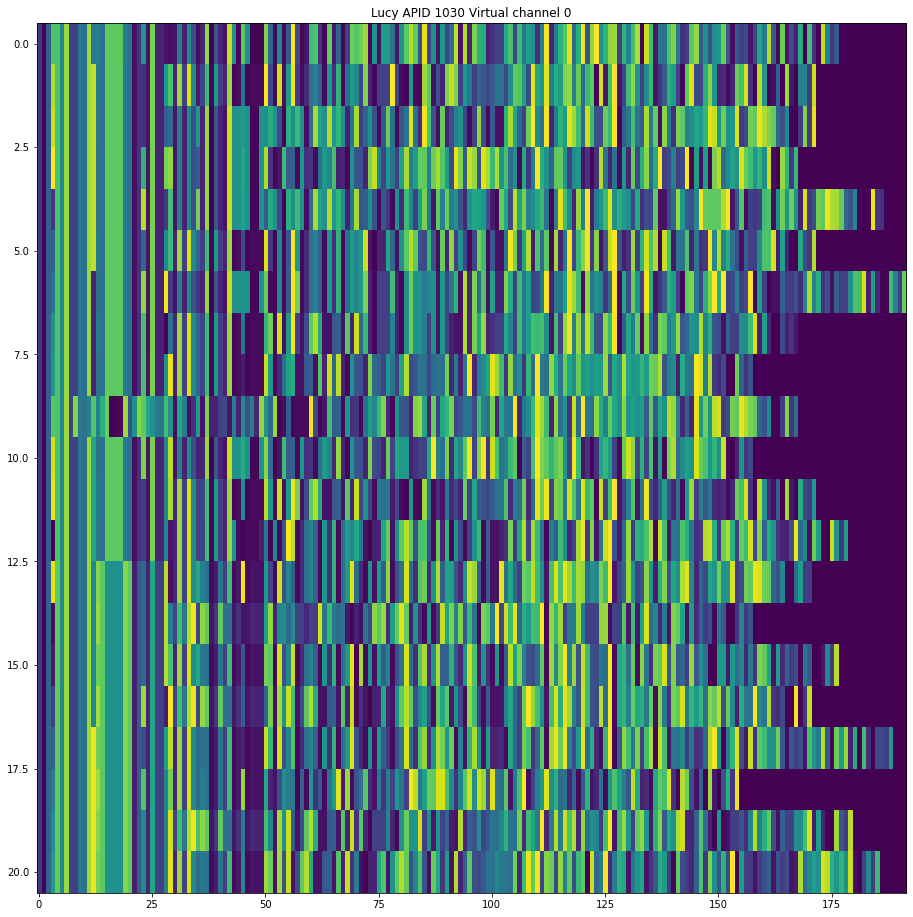

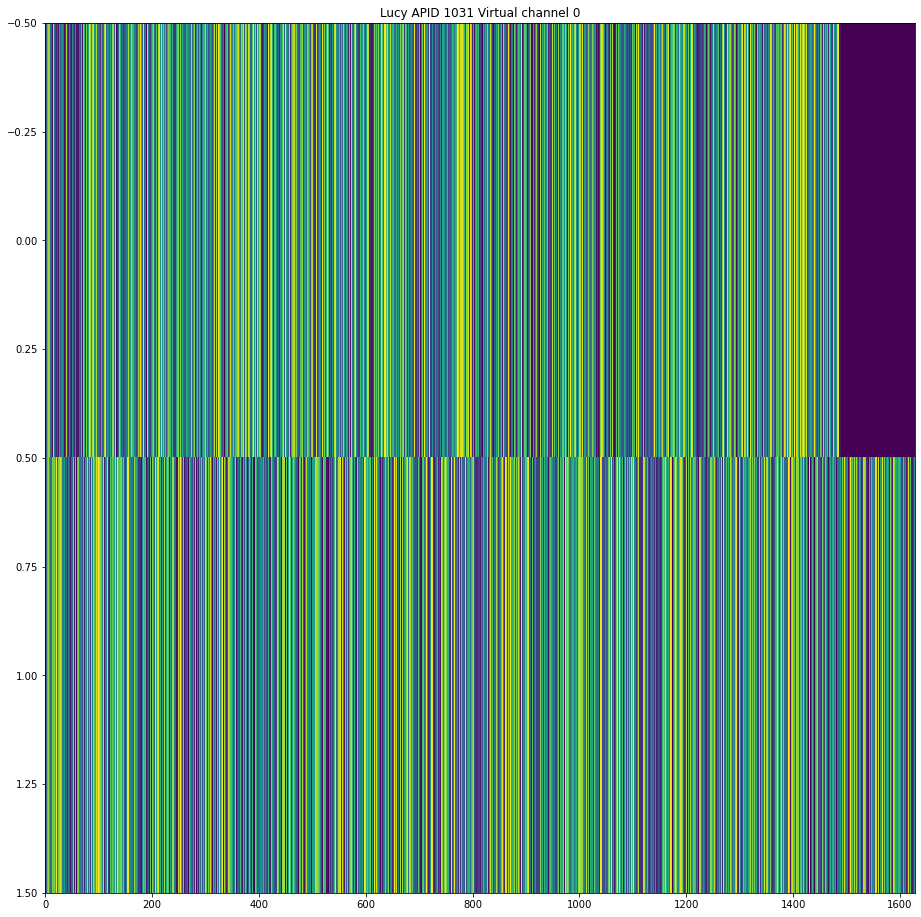

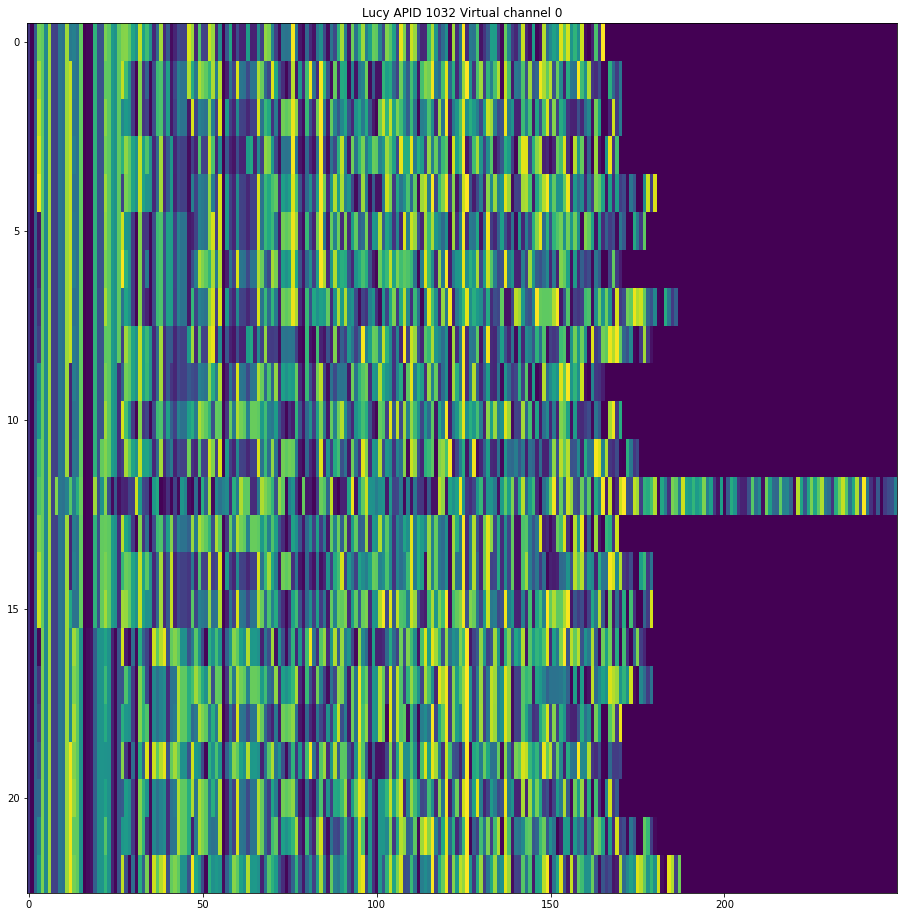

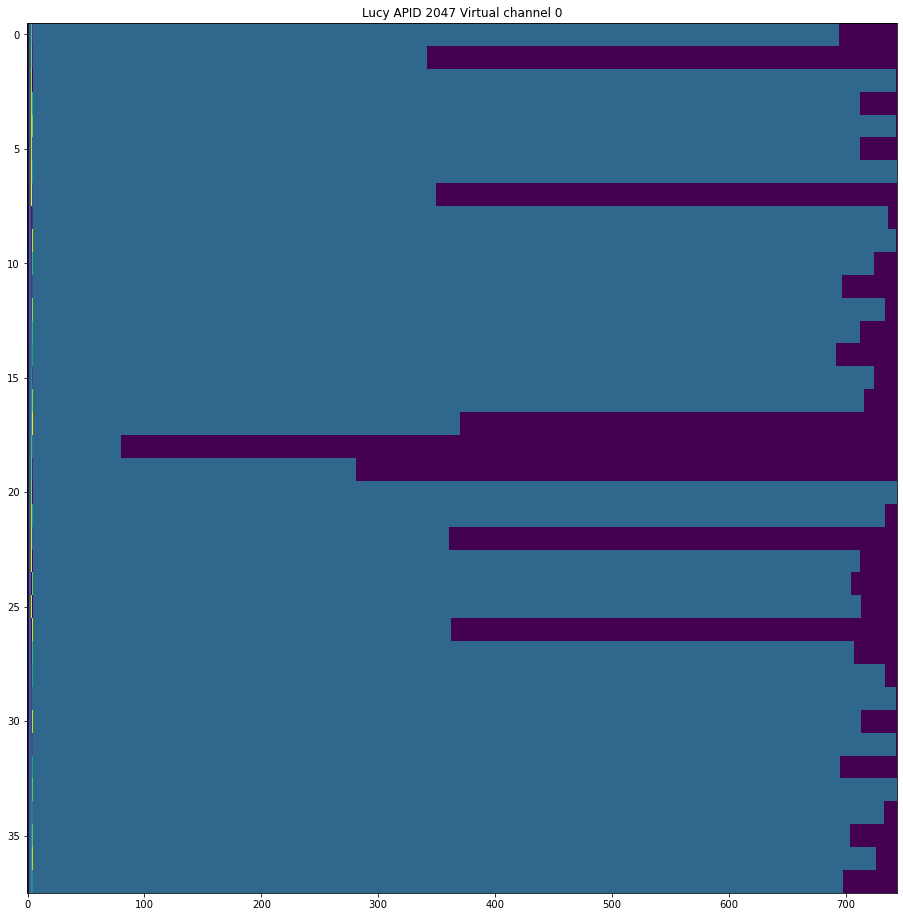

In [30]:
plot_apids(vc0_by_apid)

### APID 5

As [found by r00t](https://twitter.com/r2x0t/status/1449760174009462784) this APID has frames of fixed size containing a number of fields in tag-value format. Tags are 2 bytes, and values have different formats and sizes depending on the tag.

In [31]:
tags = {2: Int16ub, 3: Int16ub, 15: Int32ub, 31: Int16ub, 32: Int16ub, 1202: Float64b,
        1203: Float64b, 1204: Float64b, 1205: Float64b, 1206: Float64b, 1208: Float32b,
        1209: Float32b, 1210: Float32b, 1601: Float32b, 1602: Float32b, 1603: Float32b,
        1630: Float32b, 1631: Float32b, 1632: Float32b, 17539: Float32b, 17547: Float32b,
        17548: Float32b, 21314: Int32sb, 21315: Int32sb, 21316: Int32sb, 21317: Int32sb,
        46555: Int32sb, 46980: Int16ub, 46981: Int16ub, 46982: Int16ub, 47090: Int16ub,
        47091: Int16ub, 47092: Int16ub,
       }

In [32]:
values = list()
for packet in vc0_by_apid[5]:
    t = timestamps([packet])[0]
    packet = packet[6+5:]  # skip primary and secondary headers
    while True:
        tag = Int16ub.parse(packet)
        packet = packet[2:]
        value = tags[tag].parse(packet)
        packet = packet[tags[tag].sizeof():]
        values.append((tag, value, t))
        if len(packet) == 0:
            break
            
values_keys = {v[0] for v in values}
values = {k: [(v[2], v[1]) for v in values if v[0] == k] for k in values_keys}

<ipython-input-33-6d3e25884fd7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


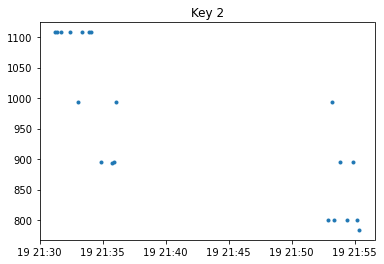

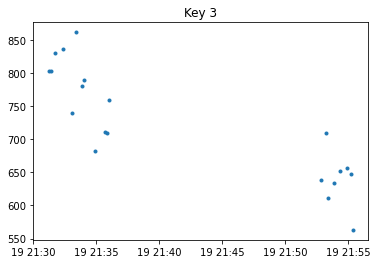

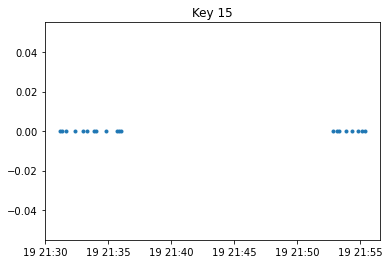

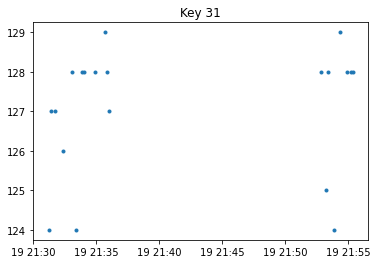

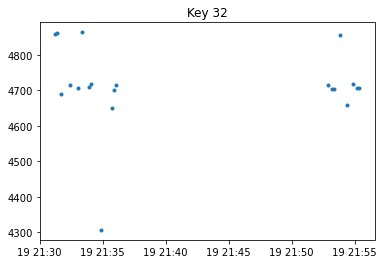

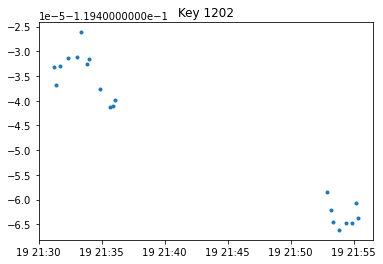

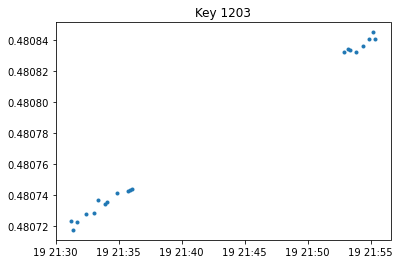

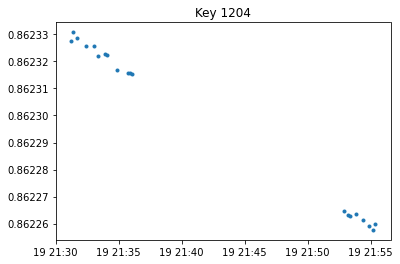

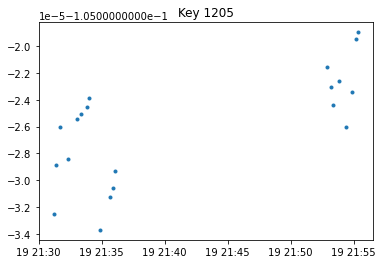

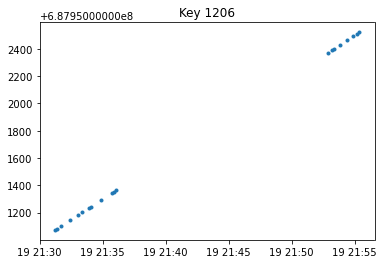

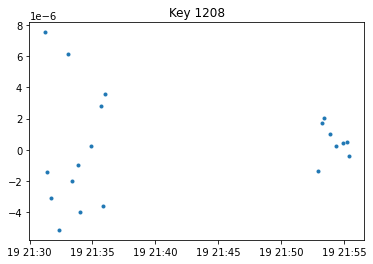

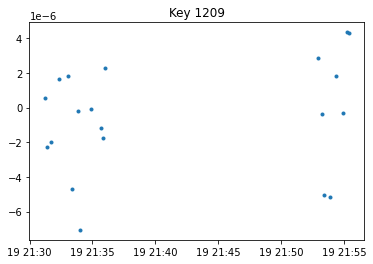

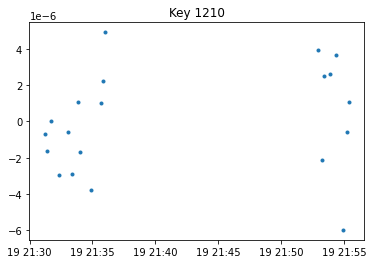

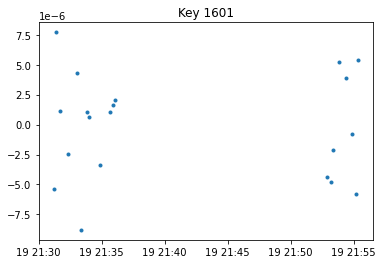

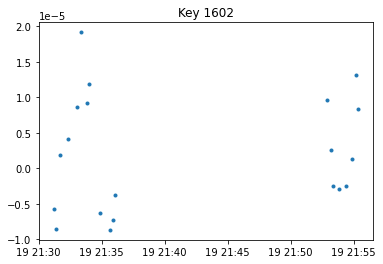

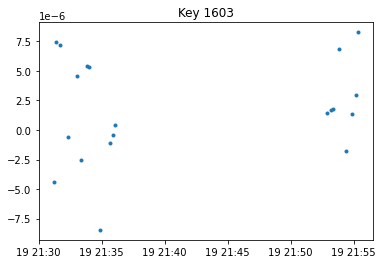

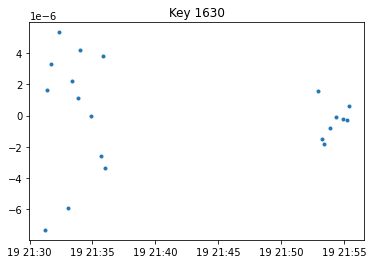

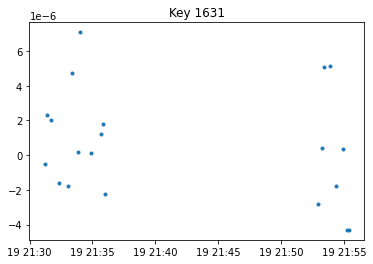

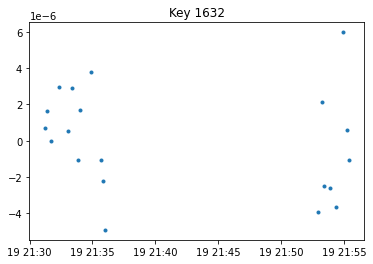

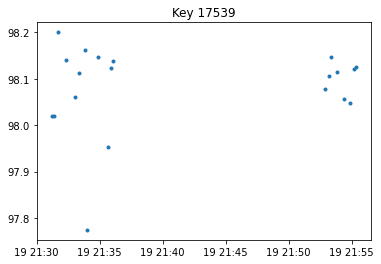

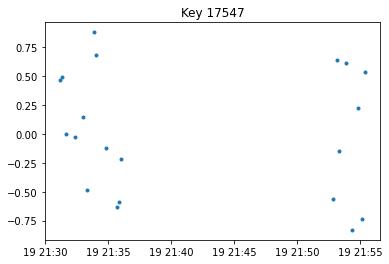

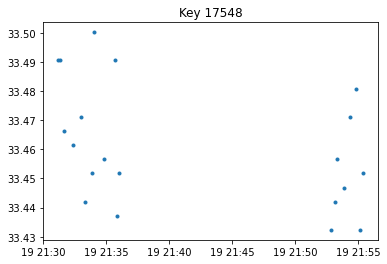

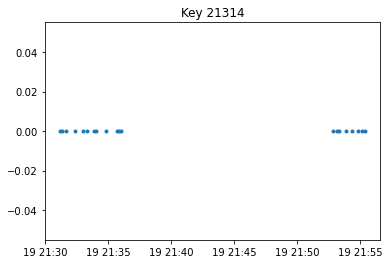

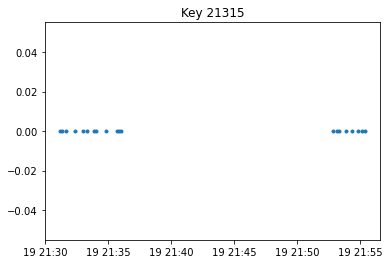

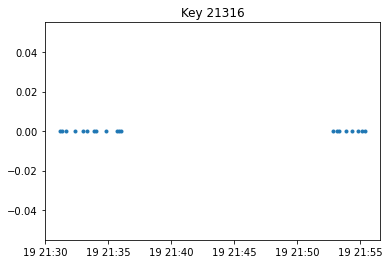

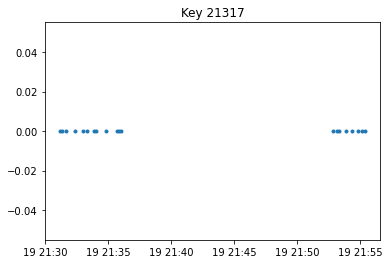

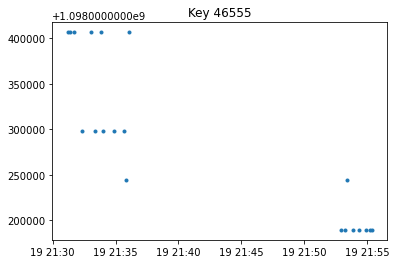

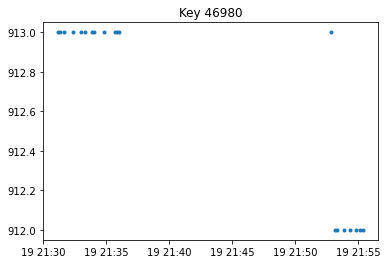

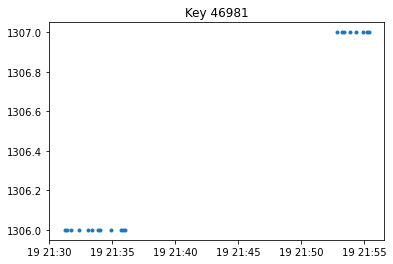

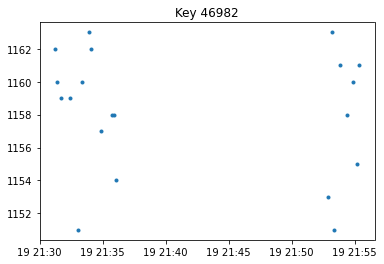

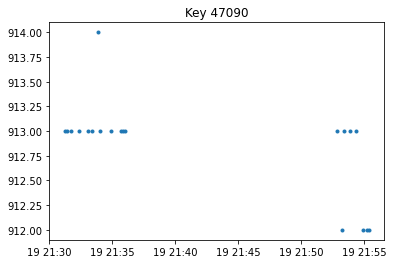

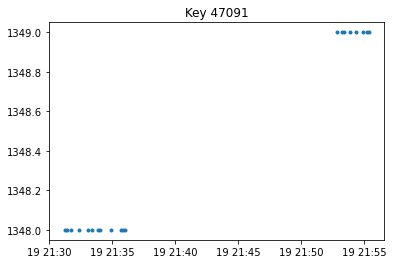

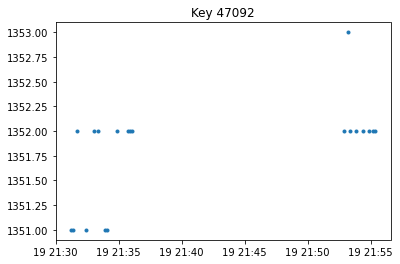

In [33]:
for k in sorted(values_keys):
    vals = values[k]
    plt.figure()
    plt.title(f'Key {k}')
    plt.plot([v[0] for v in vals], [v[1] for v in vals], '.')